This notebook examines how genre list length correlates with gender.

The model that looks to be statistically significant splits the data into two bins: length $\leq 5$ and length $\geq 6$. For each bin, calculate
$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$
where the expected number of male artists in a bin is ${\% \text{male in total sample} \cdot \text{total in bin}}$. For the first bin, with the number of genre labels $\leq 5$, the ratio is $1$ within expected error rates. However, for the second bin, male artists are over represented and female artists are under represented.

- [x] look at how estimate of ratio expected/actual for each gender varies as the proportion of data used for the estimate grows from 10% to 100%, (possibly using CV for each estimate)
- [ ] add error bars showing 2*std

In [1]:
import numpy as np
import pandas as pd

seed = 23

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
#%matplotlib notebook

from sklearn.model_selection import KFold

import re

from functools import partial

import plotly.graph_objects as go

from nested_subsets import NestedSubsets

Import the cleaned data:

In [3]:
%ls -lt ../../data/genre_lists/data_ready_for_model/

total 39824
-rw-r--r--  1 Daniel  staff    21724 Jun  9 11:47 genre_label_counts_TOTAL_2020-05-18-10-06.csv
-rw-r--r--@ 1 Daniel  staff   287510 Jun  4 13:42 genre_stats.html
-rw-r--r--@ 1 Daniel  staff   911587 Jun  4 13:39 genre_set_counts.html
-rw-r--r--@ 1 Daniel  staff     1845 Jun  4 13:11 female_bias_freq500.html
-rw-r--r--@ 1 Daniel  staff     1459 Jun  4 13:11 male_bias_freq500.html
-rw-r--r--  1 Daniel  staff    73746 May 29 10:19 genre_stats.csv
-rw-r--r--  1 Daniel  staff    66235 May 21 11:00 promiscuity_table.csv
-rw-r--r--  1 Daniel  staff    57474 May 20 12:47 corpus.mm.index
-rw-r--r--  1 Daniel  staff   382436 May 20 12:47 corpus.mm
-rw-r--r--  1 Daniel  staff    49966 May 20 12:47 genre_dictionary.dict
drwxr-xr-x  5 Daniel  staff      160 May 20 10:59 logistic_model_data/
-rw-r--r--  1 Daniel  staff    10926 May 18 11:10 genre_label_non-lonely_TRAINING_2020-05-18-10-06.csv
-rw-r--r--  1 Daniel  staff     8664 May 18 11:09 genre_label_lonely_TRAINING_2020-05-18-10-06.

In [42]:
%store -r now
now
#now = '2020-05-11-14-35'

'2020-05-18-10-06'

In [43]:
X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

In [44]:
X_train.head()

,genrelist,genrelist_length
artist,,
Pablo_Holman,"['pop', 'rock', 'emo_pop']",3
Bobby_Edwards,['country'],1
La_Palabra,"['afro_cuban_jazz', 'son_montuno', 'guaracha',...",4
Sherrick,"['r_and_b', 'soul']",2
Allen_Collins,['southern_rock'],1


In [45]:
X_train.shape, y_train.shape

((12376, 2), (12376, 1))

In [46]:
data = y_train.join( [X_train], how = 'outer')

In [47]:
data.head()

,gender,genrelist,genrelist_length
artist,,,
Pablo_Holman,male,"['pop', 'rock', 'emo_pop']",3
Bobby_Edwards,male,['country'],1
La_Palabra,male,"['afro_cuban_jazz', 'son_montuno', 'guaracha',...",4
Sherrick,male,"['r_and_b', 'soul']",2
Allen_Collins,male,['southern_rock'],1


In [48]:
data.shape, data.isnull().sum()

((12376, 3),
 gender              0
 genrelist           0
 genrelist_length    0
 dtype: int64)

### Genre Labels

Each value of the genre column is a _string_ of comma separated genre labels. We want to convert it to a _list_ of strings.

In [49]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

Now we apply it to the whole column and put the lists in a new column:

In [50]:
data['genrelist']= data['genrelist'].apply(genrelist)

In [51]:
data.head()

,gender,genrelist,genrelist_length
artist,,,
Pablo_Holman,male,"[pop, rock, emo_pop]",3
Bobby_Edwards,male,[country],1
La_Palabra,male,"[afro_cuban_jazz, son_montuno, guaracha, salsa...",4
Sherrick,male,"[r_and_b, soul]",2
Allen_Collins,male,[southern_rock],1


### Extract unique genre labels: 

### This is for the training set:

In [52]:
# genre_list = data.genrelist.values.tolist()
# genre_list = [x for y in genre_list for x in y]
# genre_list = list(set(genre_list))

### Import the labels from the whole data set:

In [53]:
then = '2020-05-11-14-34'

In [54]:
genrelist_df = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now), index_col = 'Unnamed: 0')

In [55]:
data_male = data[data.gender == 'male']
data_female = data[data.gender == 'female']

In [56]:
tot = data.shape[0]
mal = data_male.shape[0]
fem = data_female.shape[0]
print('{} total artists'.format(tot))
print('There are {} unique genre labels.'.format(genrelist_df.shape[0]))
print('{} female artists, or {:0.0f}%'.format(fem, 100*fem/(fem+mal)))
print('{} male artists, or {:0.0f}%'.format(mal, 100*mal/(fem+mal)))

12376 total artists
There are 1494 unique genre labels.
3847 female artists, or 31%
8529 male artists, or 69%


## Calculate ratios of actual to expected for male and female using two bins for list lengths: <6 and >5 

### This function creates a DF with the frequencies of the lengths of lists by gender for a df of the type of "data" above. It is used in the bin_cv_est function below.

In [57]:
def create_length_counts_by_gender(df):
    """df is """
    
    #length counts total
    dft = df.groupby(['genrelist_length']).count()
    dft.drop(['gender'], axis = 1, inplace = True)
    dft.columns = ['artist_count']
    
    # length counts by gender
    df = df.groupby(['genrelist_length','gender']).count()
    df.columns = ['artist_count']

    df.reset_index(inplace = True)
    df.set_index(['genrelist_length'], inplace = True)
    df = df.pivot(columns = 'gender')
    
    #flatten index and replace with single strings
    df.columns = df.columns.to_flat_index()
    df.columns = [name[1] for name in df.columns]
    #combine total count with gender counts
    dft.columns = ['total']
    df = dft.join(df, how = 'outer')
    
    df.fillna(value = {'female': 0}, inplace = True)
    
    return df

In [58]:
lcbg = create_length_counts_by_gender(data)

In [59]:
lcbg

,total,female,male
genrelist_length,,,
1,3561,1031.0,2530.0
2,3067,1030.0,2037.0
3,2488,854.0,1634.0
4,1594,502.0,1092.0
5,850,243.0,607.0
6,462,127.0,335.0
7,181,27.0,154.0
8,92,15.0,77.0
9,37,9.0,28.0


### The bin_est function estimates actual/expected ratios for male and female by genre list length by binning the data into < 6 and > 5 bins.

In [60]:
def bin_est(df):
    
    # create length counts by gender
    lcbg = create_length_counts_by_gender(df)

    # mark rows by their class (uses ordering; could be done with masking)
    lcbg['classify'] = '1-5'
    lcbg.iloc[6:,-1] = '>5'

    # calculate totals for each bin
    twobins = lcbg.groupby(['classify']).agg('sum')

    # calculated columns: expected and ratios 
    twobins['expected female'] = (.31*twobins['total']).astype('int64')
    twobins['expected male'] = (.69*twobins['total']).astype('int64')
    twobins['male_act_exp_ratio'] =twobins['male']/ twobins['expected male']
    twobins['female_act_exp_ratio'] =  twobins['female']/ twobins['expected female']

    # only keep needed columns
    twobins = twobins[['male_act_exp_ratio','female_act_exp_ratio']]

    return twobins

In [61]:
twobins = bin_est(data)

In [62]:
twobins

,male_act_exp_ratio,female_act_exp_ratio
classify,,
1-5,0.992767,1.016371
>5,1.204918,0.550459


In [63]:
k = 2
indices = [[0,1,2], ['1-5','>5']]
columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
biases0 = pd.DataFrame(index = pd.MultiIndex.from_product(indices), columns = pd.MultiIndex.from_product(columns), dtype = float)
biases0

run_0                                   run_1  \
      female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
0 1-5                  NaN                NaN                  NaN   
  >5                   NaN                NaN                  NaN   
1 1-5                  NaN                NaN                  NaN   
  >5                   NaN                NaN                  NaN   
2 1-5                  NaN                NaN                  NaN   
  >5                   NaN                NaN                  NaN   

                          
      male_act_exp_ratio  
0 1-5                NaN  
  >5                 NaN  
1 1-5                NaN  
  >5                 NaN  
2 1-5                NaN  
  >5                 NaN

In [64]:
twobins = bin_est(data)
indices = [[2],['1-5', '>5']]
columns = [['run_1'],['female_act_exp_ratio','male_act_exp_ratio']]
twobins.index = pd.MultiIndex.from_product(indices)
twobins.columns = pd.MultiIndex.from_product(columns)

In [65]:
twobins

run_1                   
      female_act_exp_ratio male_act_exp_ratio
2 1-5             0.992767           1.016371
  >5              1.204918           0.550459

In [66]:
# size = 1
i = 1
# biases0.at[(size,'1-5'):(size,'>5'),(f'run_{i}', 'female_act_exp_ratio'):(f'run_{i}', 'male_act_exp_ratio')] = twobins
# biases0.loc[(slice(0,1),slice('1-5','>5')),(slice(f'run_{i}'), ['female_act_exp_ratio', 'male_act_exp_ratio'])] = twobins

idx = pd.IndexSlice
biases0.loc[idx[2,['1-5','>5']],idx[[f'run_{i}'], ['female_act_exp_ratio', 'male_act_exp_ratio']]] = twobins

In [67]:
biases0

run_0                                   run_1  \
      female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
0 1-5                  NaN                NaN                  NaN   
  >5                   NaN                NaN                  NaN   
1 1-5                  NaN                NaN                  NaN   
  >5                   NaN                NaN                  NaN   
2 1-5                  NaN                NaN             0.992767   
  >5                   NaN                NaN             1.204918   

                          
      male_act_exp_ratio  
0 1-5                NaN  
  >5                 NaN  
1 1-5                NaN  
  >5                 NaN  
2 1-5           1.016371  
  >5            0.550459

In [68]:
twobins = bin_est(data)
indices = [[3],['1-5', '>5']]
columns = [['run_1'],['female_act_exp_ratio','male_act_exp_ratio']]
twobins.index = pd.MultiIndex.from_product(indices)
twobins.columns = pd.MultiIndex.from_product(columns)

In [69]:
twobins

run_1                   
      female_act_exp_ratio male_act_exp_ratio
3 1-5             0.992767           1.016371
  >5              1.204918           0.550459

Extend the index range:

In [70]:
indices = [[3], ['1-5','>5']]
#columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
biases0.set_index(biases0.index.append(pd.MultiIndex.from_product(indices)))
biases0

ValueError: Length mismatch: Expected 6 rows, received array of length 8

In [71]:
# size = 1
i = 1
# biases0.at[(size,'1-5'):(size,'>5'),(f'run_{i}', 'female_act_exp_ratio'):(f'run_{i}', 'male_act_exp_ratio')] = twobins
# biases0.loc[(slice(0,1),slice('1-5','>5')),(slice(f'run_{i}'), ['female_act_exp_ratio', 'male_act_exp_ratio'])] = twobins

idx = pd.IndexSlice
biases0.at[idx[3,['1-5','>5']],idx[[f'run_{i}'], ['female_act_exp_ratio', 'male_act_exp_ratio']]] = twobins

KeyError: 3

In [72]:
biases0

run_0                                   run_1  \
      female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
0 1-5                  NaN                NaN                  NaN   
  >5                   NaN                NaN                  NaN   
1 1-5                  NaN                NaN                  NaN   
  >5                   NaN                NaN                  NaN   
2 1-5                  NaN                NaN             0.992767   
  >5                   NaN                NaN             1.204918   

                          
      male_act_exp_ratio  
0 1-5                NaN  
  >5                 NaN  
1 1-5                NaN  
  >5                 NaN  
2 1-5           1.016371  
  >5            0.550459

In [73]:
k = 1 # runs
m = 1 # sizes

# create empty DF
#biases_indices = [[i for i in range(m)], ['1-5','>5']]
biases_indices = [[-1], ['1-5','>5']]
biases_columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
biases0 = pd.DataFrame(index = pd.MultiIndex.from_product(biases_indices), columns = pd.MultiIndex.from_product(biases_columns), dtype = float)
#print(biases0) initializes ok with NaN
for i in range(k): 
    for size in range(m):
        twobins = bin_est(data)
        indices = [[size],['1-5', '>5']]
        columns = [[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]
        #print(indices)
        #print(biases_indices)
        #biases_indices = biases_indices.append([[size],['1-5', '>5']])
        #print(biases_indices)
        twobins.index = pd.MultiIndex.from_product(indices)
        twobins.columns = pd.MultiIndex.from_product(columns)
        print(twobins.index)
        biases0.MultiIndex = biases0.MultiIndex.append(pd.MultiIndex.from_product(biases_indices))
        print(biases0.index)
        #biases0.at[(size,'1-5'):(size,'>5'),(f'run_{i}', 'female_act_exp_ratio'):(f'run_{i}', 'male_act_exp_ratio')] = twobins

MultiIndex([(0, '1-5'),
            (0,  '>5')],
           )


AttributeError: 'DataFrame' object has no attribute 'MultiIndex'

Use nested_subsets.py script to generate nested subsets.

In [74]:
subsets = NestedSubsets(data)

In [75]:
!cat nested_subsets.py

import numpy as np
import pandas as pd

class NestedSubsets():
    """Generate nested subsets of a data set.
    Input: a pd.DataFrame, an optional step_size, and an optional percentage.
    Step_size overrides percentage.
    
    Output: an iterator whose elements are nested subsets of the input, 
    decreasing in size. The decrease in size is step_size or the 
    prescribed percentage of the input."""
    def __init__(self, data, step_size = None, percentage = 0.1):
        self.data = data
        self.sample = data.sample(data.shape[0]) # full data set
        self.step_size = int(percentage * data.shape[0])
        if step_size: self.step_size = step_size # minium subsample size
        self.remainder_size = self.sample.shape[0] % self.step_size # remainder subset
        self.sample_size = self.sample.shape[0] # initial subsample size

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.sample_size == 0:
            raise StopIteration
    

In [76]:
next(subsets).shape[0]

12376

In [77]:
subsets.get_number_of_steps()

10

Test binning with nestedsubsets:

In [78]:
bin_est(next(subsets))

,male_act_exp_ratio,female_act_exp_ratio
classify,,
1-5,0.992767,1.016398
>5,1.200913,0.561224


### Calculate ratios for multiple nested subsamples along with the mean and std of the k runs

Attempting to update values of an initialized DF:

In [89]:
# set the number of runs
k = 2

# Set percentage or step_size; step_size overrides percentage
percentage = .1
step_size = None

# initialize a DataFrame to save biases calculated for each nested subsample
# call NestedSubsets to get the_number_of_subsets and step_size
subsets = NestedSubsets(data, step_size, percentage = percentage)
number_of_steps = subsets.get_number_of_steps()
step_size = subsets.get_step_size()
# create list of sizes of subsets to use as index
sizes = [data.shape[0]-j*step_size for j in range(number_of_steps)]
# create MultiIndex
indices = [sizes, ['1-5','>5']]
columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
biases = pd.DataFrame(index = pd.MultiIndex.from_product(indices), columns = pd.MultiIndex.from_product(columns), dtype = float)
idx = pd.IndexSlice
for i in range(k): # perform k runs
    # create the subset generator
    subsets = NestedSubsets(data, step_size, percentage = percentage)
    step_size = subsets.get_step_size()
    for subset in subsets:
        size = subset.shape[0]
        if size >= step_size: # excluding the remainder samples
            twobins = bin_est(subset)
            # set indices to match the slice relevant ones of biases 
            indices = [[size],['1-5', '>5']]
            columns = [[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]
            twobins.index = pd.MultiIndex.from_product(indices)
            twobins.columns = pd.MultiIndex.from_product(columns)
            # append the new set of values
            biases.loc[idx[[size],['1-5', '>5']],idx[[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]] = twobins
#   
# biases.index.names = ['size','bin']
# biases.columns.names = ['runs','gender']

# means = biases.groupby(['gender'], axis = 1).mean()
# means.columns = pd.MultiIndex.from_product([['means'],['fem mean','mal mean']])
# stds = biases.groupby(['gender'], axis = 1).std()
# stds.columns = pd.MultiIndex.from_product([['stds'],['fem std','mal std']])
# biases = biases.join([means, stds])

# # fix these to be female/male
# # biases[('mean','female_act_exp_ratio')] = biases.mean(axis = 1)
# # biases['std'] = biases.std(axis = 1)
# # err.index.name = 'size'

In [90]:
biases

run_0                                   run_1  \
          female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
12376 1-5             0.992767           1.016371             0.992767   
      >5              1.204918           0.550459             1.204918   
11139 1-5             0.992636           1.016692             0.992493   
      >5              1.208333           0.546392             1.209821   
9902  1-5             0.991716           1.018779             0.994118   
      >5              1.202073           0.558140             1.208955   
8665  1-5             0.989320           1.024156             0.995003   
      >5              1.190751           0.584416             1.213873   
7428  1-5             0.993173           1.015646             0.993578   
      >5              1.187500           0.600000             1.225352   
6191  1-5             0.993736           1.014485             0.991093   
      >5              1.208333           0.555556             1.230769   
4954  1-5             0.984337           1.035547             0.988862   
      >5              1.226804           0.522727             1.231579   
3717  1-5             0.976267           1.053715             0.983160   
      >5              1.259740           0.457143             1.257143   
2480  1-5             0.972859           1.061745             0.970464   
      >5              1.230769           0.521739             1.235294   
1243  1-5             0.992771           1.018817             0.968712   
      >5              1.370370           0.250000             1.192308   

                              
          male_act_exp_ratio  
12376 1-5           1.016371  
      >5            0.550459  
11139 1-5           1.017005  
      >5            0.544554  
9902  1-5           1.013427  
      >5            0.544444  
8665  1-5           1.011503  
      >5            0.538462  
7428  1-5           1.014745  
      >5            0.507937  
6191  1-5           1.020364  
      >5            0.500000  
4954  1-5           1.025469  
      >5            0.511628  
3717  1-5           1.038393  
      >5            0.451613  
2480  1-5           1.067114  
      >5            0.521739  
1243  1-5           1.072386  
      >5            0.636364

Appending: (not a great approach because need to join runs and append sizes)

In [38]:
# set the number of runs
k = 2

# Set percentage or step_size; step_size overrides percentage
percentage = .1
step_size = None

# initialize a DataFrame to save biases calculated for each nested subsample
indices = [[], ['1-5','>5']]
columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
biases = pd.DataFrame(index = pd.MultiIndex.from_product(indices), columns = pd.MultiIndex.from_product(columns), dtype = float)

for i in range(k): # perform k runs
    # create the subset generator
    subsets = NestedSubsets(data, step_size, percentage = percentage)
    step_size = subsets.get_step_size()
    for subset in subsets:
        size = subset.shape[0]
        if size >= step_size: # excluding the remainder samples
            twobins = bin_est(subset)
            # set indices to match the slice relevant ones of biases 
            indices = [[size],['1-5', '>5']]
            columns = [[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]
            twobins.index = pd.MultiIndex.from_product(indices)
            twobins.columns = pd.MultiIndex.from_product(columns)
            # append the new set of values
            biases = biases.append([twobins])
  
# biases.index.names = ['size','bin']
# biases.columns.names = ['runs','gender']

# means = biases.groupby(['gender'], axis = 1).mean()
# means.columns = pd.MultiIndex.from_product([['means'],['fem mean','mal mean']])
# stds = biases.groupby(['gender'], axis = 1).std()
# stds.columns = pd.MultiIndex.from_product([['stds'],['fem std','mal std']])
# biases = biases.join([means, stds])

# # fix these to be female/male
# # biases[('mean','female_act_exp_ratio')] = biases.mean(axis = 1)
# # biases['std'] = biases.std(axis = 1)
# # err.index.name = 'size'

In [39]:
biases

run_0                                   run_1  \
          female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
12376 1-5             0.992767           1.016371                  NaN   
      >5              1.204918           0.550459                  NaN   
11139 1-5             0.992229           1.017596                  NaN   
      >5              1.203620           0.555556                  NaN   
9902  1-5             0.994123           1.013418                  NaN   
      >5              1.200000           0.568182                  NaN   
8665  1-5             0.993286           1.015332                  NaN   
      >5              1.207101           0.552632                  NaN   
7428  1-5             0.990361           1.021904                  NaN   
      >5              1.208333           0.553846                  NaN   
6191  1-5             0.984356           1.035351                  NaN   
      >5              1.234783           0.500000                  NaN   
4954  1-5             0.973842           1.058902                  NaN   
      >5              1.219780           0.536585                  NaN   
3717  1-5             0.970741           1.066012                  NaN   
      >5              1.202899           0.548387                  NaN   
2480  1-5             0.975962           1.054886                  NaN   
      >5              1.217391           0.571429                  NaN   
1243  1-5             0.961538           1.088235                  NaN   
      >5              1.333333           0.363636                  NaN   
12376 1-5                  NaN                NaN             0.992767   
      >5                   NaN                NaN             1.204918   
11139 1-5                  NaN                NaN             0.992098   
      >5                   NaN                NaN             1.210046   
9902  1-5                  NaN                NaN             0.988547   
      >5                   NaN                NaN             1.210256   
8665  1-5                  NaN                NaN             0.984165   
      >5                   NaN                NaN             1.202381   
7428  1-5                  NaN                NaN             0.989148   
      >5                   NaN                NaN             1.216216   
6191  1-5                  NaN                NaN             0.989646   
      >5                   NaN                NaN             1.211864   
4954  1-5                  NaN                NaN             0.984680   
      >5                   NaN                NaN             1.191011   
3717  1-5                  NaN                NaN             0.984412   
      >5                   NaN                NaN             1.161290   
2480  1-5                  NaN                NaN             0.979042   
      >5                   NaN                NaN             1.150000   
1243  1-5                  NaN                NaN             0.980907   
      >5                   NaN                NaN             1.052632   

                              
          male_act_exp_ratio  
12376 1-5                NaN  
      >5                 NaN  
11139 1-5                NaN  
      >5                 NaN  
9902  1-5                NaN  
      >5                 NaN  
8665  1-5                NaN  
      >5                 NaN  
7428  1-5                NaN  
      >5                 NaN  
6191  1-5                NaN  
      >5                 NaN  
4954  1-5                NaN  
      >5                 NaN  
3717  1-5                NaN  
      >5                 NaN  
2480  1-5                NaN  
      >5                 NaN  
1243  1-5                NaN  
      >5                 NaN  
12376 1-5           1.016371  
      >5            0.550459  
11139 1-5           1.017889  
      >5            0.540816  
9902  1-5           1.025830  
      >5            0.545455  
8665  1-5           1.035632  
      >5         

In [40]:
biases.loc[(size,'1-5'):(size,'>5'),(f'run_{i}', 'female_act_exp_ratio'):(f'run_{i}', 'male_act_exp_ratio')]

UnsortedIndexError: 'Key length (2) was greater than MultiIndex lexsort depth (0)'

In [ ]:
biases

In [ ]:
twobins

### OLD VERSION: Calculate ratios for multiple nested subsamples along with the mean and std of the k runs

In [ ]:
# # choose the number of nested sequences for which to calculate the errors
# k = 20
# n = 20
# # call the nested_subsamples function to calculate the sample_sizes
# sample_sizes, subsamples = nested_subsamples(data, n)
# # initialize an array to save the errors
# indices = [sample_sizes.tolist(), ['1-5','>5']]
# columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
# biases = pd.DataFrame(index = pd.MultiIndex.from_product(indices), columns = pd.MultiIndex.from_product(columns), dtype = float)
# for i in range(k):
#     sample_sizes, subsamples = nested_subsamples(data, n)
#     for size_ind, bin_ind in biases.index:
#         twobins = bin_cv_est(subsamples[size_ind])
#         biases.at[(size_ind, bin_ind),(f'run_{i}','female_act_exp_ratio')] = twobins.at[bin_ind,'female_act_exp_ratio']
#         biases.at[(size_ind, bin_ind),(f'run_{i}','male_act_exp_ratio')] = twobins.at[bin_ind,'male_act_exp_ratio']

# biases.index.names = ['size','bin']
# biases.columns.names = ['runs','gender']

# means = biases.groupby(['gender'], axis = 1).mean()
# means.columns = pd.MultiIndex.from_product([['means'],['fem mean','mal mean']])
# stds = biases.groupby(['gender'], axis = 1).std()
# stds.columns = pd.MultiIndex.from_product([['stds'],['fem std','mal std']])
# biases = biases.join([means, stds])

# # fix these to be female/male
# # biases[('mean','female_act_exp_ratio')] = biases.mean(axis = 1)
# # biases['std'] = biases.std(axis = 1)
# # err.index.name = 'size'

In [ ]:
bias_means = biases[['means']]
bias_stds = biases[['stds']]

# Add in error bars with 2*std

NameError: name 'bias_means' is not defined

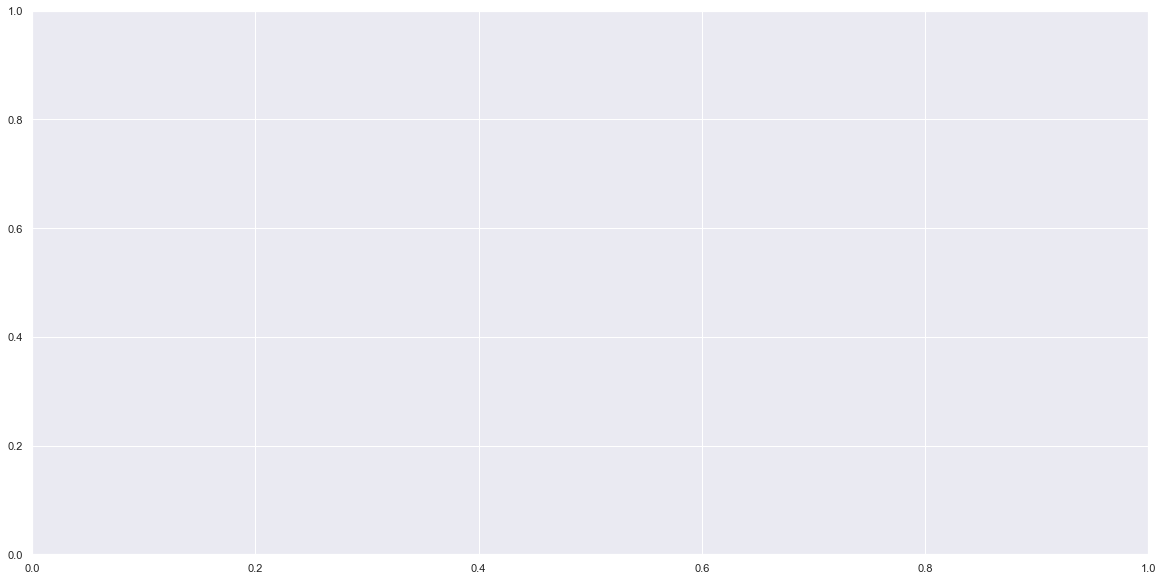

In [41]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
bias_means.plot(use_index = True, kind = 'bar', ax = ax )
#ax.errorbar(, bias_means, yerr = bias_stds)

### Use below as model for adjusting the bargraph above

In [ ]:
df = twobins_folds_train_mean
eb = twobins_folds_train_std
fig, axs = plt.subplots(1,2, sharey = True, figsize = (10,10))
fig.suptitle('The ratio of actual to expected percentages of artists. The error bars show one STD', fontsize = 20)
axs[0].bar([0,1],df.iloc[0].to_list(), color = ['orange','purple'], yerr = eb.iloc[0].to_list(), capsize = 16)
axs[1].bar([0,1],df.iloc[1].to_list(), color = ['orange','purple'], yerr = eb.iloc[1].to_list(), capsize = 16)
axs[0].set_xticklabels([None,'male',None,'female'], fontsize = 16, rotation = 0)
axs[1].set_xticklabels([None,'male',None,'female'], fontsize = 16, rotation = 0)
axs[0].set_xlabel('1-5 genre labels', fontsize = 16)
axs[1].set_xlabel('6 or more genre labels', fontsize = 16)
axs[0].axhline(1, color = 'cyan', ls = '--')
axs[1].axhline(1, color = 'cyan', ls = '--')
plt.setp(axs[1].get_yticklabels(), visible=False)
#caption = 'This is'
#fig.text(caption)
fig.savefig(fname = '/Users/Daniel/Code/Genre/visualizations/twobins_plot.png', format = 'png', dpi = 'figure')